In [3]:
%pip install -r ./../requirements.txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 61.6 MB/s eta 0:00:0031m66.8 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 33.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.9/348.9 kB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 15.4 MB/s eta 0:00:00
     ━━━━━

In [2]:
# imports
import pandas as pd
import tiktoken
import numpy as np

from openai.embeddings_utils import get_embedding

In [ ]:
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

Taking the 1,000 highest scoring repos from our sourcing software and embedding them using ada-002

In [ ]:
# load & inspect dataset
input_datapath = "./../data/top-1k-repos.csv"  # to save space, we provide a pre-filtered dataset
df = pd.read_csv(input_datapath, index_col=0)
df = df[["github_id", "name", "description", "score"]]
df = df.dropna()
df["combined"] = (
    "Name: " + df.name.str.strip() + "; Description: " + df.description.str.strip()
)
df.head(2)

In [ ]:
encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens]
len(df)

In [ ]:
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))
df.to_csv("./../data/top-1k-repos-with-embeddings.csv")

In [4]:
df = pd.read_csv('./../data/top-1k-repos-with-embeddings.csv')
df['embedding'] = df.embedding.apply(eval).apply(np.array)
matrix = np.vstack(df.embedding.values)
matrix.shape

(979, 1536)

In [5]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").score.mean().sort_values()

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
3    62.564516
0    65.718127
1    69.697802
2    77.375850
Name: score, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

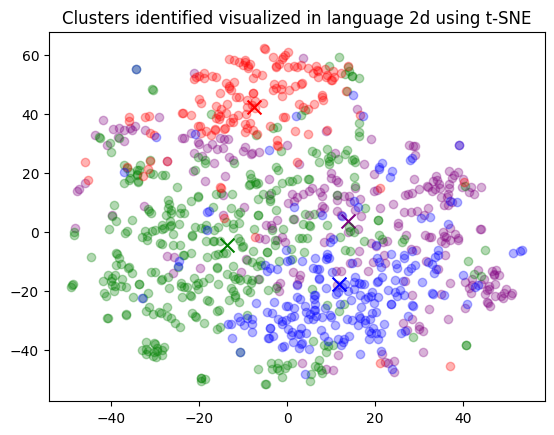

In [6]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

In [7]:
# Reading a review which belong to each group.
rev_per_cluster = 10

for i in range(n_clusters):
    print(f"Cluster {i} ", end="\n")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.score.values[j], end=", ")
        print(sample_cluster_rows.name.values[j], end=":   ")
        print(sample_cluster_rows.description.str[:70].values[j])

    print("-" * 100)

Cluster 0 
48.0, materialize:   Materialize is a fast, distributed SQL database built on streaming int
160.0, bare-metal-programming-guide:   A bare metal programming guide (ARM microcontrollers)
48.0, warehouse:   The Python Package Index
69.0, fq:   jq for binary formats - tool, language and decoders for working with b
56.0, coroot:   A monitoring and troubleshooting tool for microservice architectures.
47.5, riverpod:   A simple way to access state while robust and testable.
46.0, fselect:   Find files with SQL-like queries
46.0, registrator:   Service registry bridge for Docker with pluggable adapters
130.0, DevOps:   This repo contains all my learning related to DevOps
55.0, scc:   Sloc, Cloc and Code: scc is a very fast accurate code counter with com
----------------------------------------------------------------------------------------------------
Cluster 1 
55.0, writefreely:   A clean, Markdown-based publishing platform made for writers. Write to
110.0, stable-diffusion-ui:  